##  Evaluate Isolation Forest for credit cards anomaly detection 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import itertools

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [2]:
def plot_confusion_matrix(cm):
   
    classes=['abnormal', 'normal']
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2%'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Load data

In [3]:
#import os
#print(os.getcwd())

In [4]:
creditcard = pd.read_csv('../input/creditcard.csv')
creditcard.drop(columns='Time', inplace=True)
creditcard.drop(columns='Amount', inplace=True)

####  Features V1, V2, ... V28 are the principal components obtained with PCA

In [5]:
features = creditcard.loc[:,'V1':'V28']
features.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


#### Let's have 1 for Normal and -1 for Anomaly

In [6]:
labels = creditcard['Class'].astype(np.float32)
labels[labels == 1] = -1.0
labels[labels == 0] = 1.0

labels.value_counts()

 1.0    284315
-1.0       492
Name: Class, dtype: int64

In [7]:
#plt.figure(figsize=(20, 10))
#sns.heatmap(data.corr(), square=True, annot=True, cbar=False)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=46)

#### Number of anomalies in full data and training

In [9]:
len(labels[labels < 0]) /len(labels)

0.001727485630620034

In [10]:
len(y_train[y_train < 0]) /len(y_train)

0.0017204710980919323

#### Model

In [11]:
iforest = IsolationForest(random_state=46, n_estimators=100, contamination=0.15)

iforest.fit(X_train, y_train)
y_train_pred = iforest.predict(X_train)
y_train_scores = iforest.decision_function(X_train)

#### How scores look like

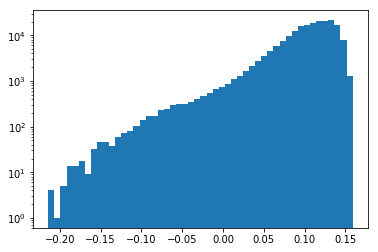

In [12]:
x = plt.hist(y_train_scores, 50,)
plt.gca().set_yscale("log")

#### Let's see Class and Score together

In [13]:
result = pd.DataFrame({'Class': y_train, 'Score': y_train_scores})
result.head()

,Class,Score
42182,1.0,0.110662
176131,1.0,0.090504
113048,1.0,0.127842
132410,1.0,0.113740
27793,1.0,0.109578


#### Hmm...there's no visual correlation between scores of Anomaly vs. Normal  :(

In [14]:
anomaly = result[result["Class"] != 1.0]["Score"]
normaly = result[result["Class"] == 1.0]["Score"]

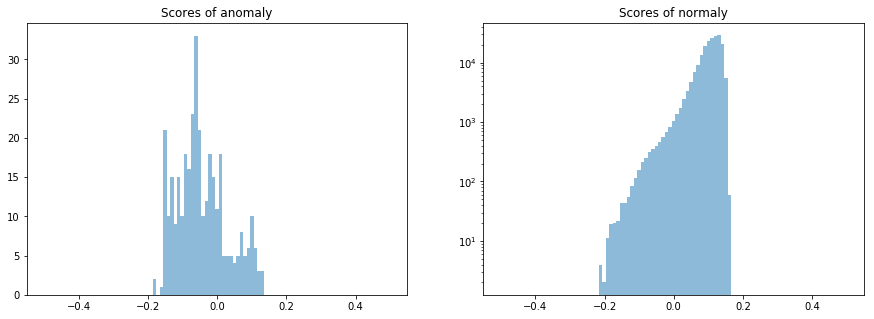

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax0, ax1 = axes.flatten()

bins = np.linspace(-0.5, 0.5, 100)

ax0.hist(anomaly, bins, alpha=0.5)
ax0.set_title('Scores of anomaly')

ax1.hist(normaly, bins, alpha=0.5)
ax1.set_yscale("log")
ax1.set_title('Scores of normaly')

plt.show()

#### Confusion Matrix (train)

In [16]:
cm = confusion_matrix(y_train, y_train_pred)

In [17]:
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train, y_train_pred)))

AUC:  87.2%


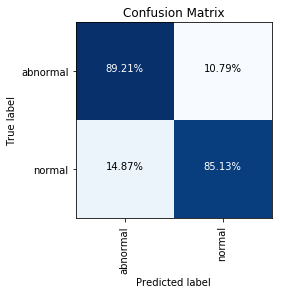

In [18]:
plot_confusion_matrix(cm)

#### Confusion Matrix (test)

In [19]:
y_test_pred = iforest.predict(X_test)

In [20]:
cm = confusion_matrix(y_test, y_test_pred)

In [21]:
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_test_pred)))

AUC:  89.3%


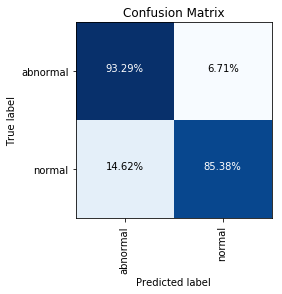

In [22]:
plot_confusion_matrix(cm)

#### Not so bad